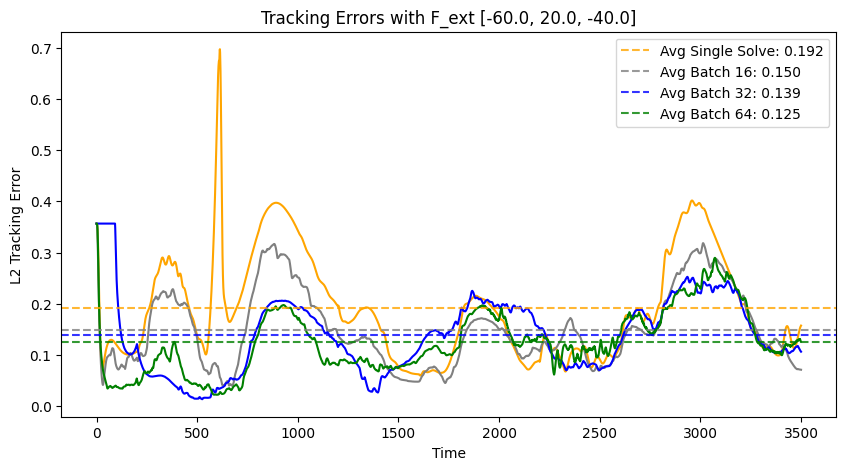

In [398]:
import os
import sys
sys.path.append('./src')
import numpy as np
import matplotlib.pyplot as plt
import time

path = "stats/single/033848"
batch_16_path = "stats/16/041954"
batch_32_path = "stats/32/035043"
batch_64_path = "stats/64/041825"

tracking_errors = np.load(f"{path}_tracking_errors.npy")
batch_16_tracking_errors = np.load(f"{batch_16_path}_tracking_errors.npy")
batch_32_tracking_errors = np.load(f"{batch_32_path}_tracking_errors.npy")
batch_64_tracking_errors = np.load(f"{batch_64_path}_tracking_errors.npy")

# plot tracking errors
plt.figure(figsize=(10, 5))
plt.plot(tracking_errors, color='orange')
plt.plot(batch_16_tracking_errors, color='gray')
plt.plot(batch_32_tracking_errors, color='blue')
plt.plot(batch_64_tracking_errors, color='green')
# show average tracking error on plot
plt.axhline(y=np.mean(tracking_errors), color='orange', linestyle='--', alpha=0.8, label=f'Avg Single Solve: {np.mean(tracking_errors):.3f}')
plt.axhline(y=np.mean(batch_16_tracking_errors), color='gray', linestyle='--', alpha=0.8, label=f'Avg Batch 16: {np.mean(batch_16_tracking_errors):.3f}')
plt.axhline(y=np.mean(batch_32_tracking_errors), color='blue', linestyle='--', alpha=0.8, label=f'Avg Batch 32: {np.mean(batch_32_tracking_errors):.3f}')
plt.axhline(y=np.mean(batch_64_tracking_errors), color='green', linestyle='--', alpha=0.8, label=f'Avg Batch 64: {np.mean(batch_64_tracking_errors):.3f}')
plt.title("Tracking Errors with F_ext [-60.0, 20.0, -40.0]")
plt.xlabel("Time")
plt.ylabel("L2 Tracking Error")
plt.legend()
plt.show()


In [379]:
def figure8(A_x, A_z, offset, period, dt, cycles):
    # First define unrotated coordinates
    x_unrot = lambda t: offset[0] + A_x * np.sin(t)  # X goes from -xamplitude to xamplitude
    y_unrot = lambda t: offset[1]
    z_unrot = lambda t: offset[2] + A_z * np.sin(2*t)/2 + A_z/2  # Z goes from -zamplitude/2 to zamplitude/2
    
    # rotation matrix for 45 degrees around z-axis
    R = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4), 0.0],
                  [np.sin(np.pi/4), np.cos(np.pi/4), 0.0],
                  [0.0, 0.0, 1.0]])
    
    # apply rotation to coordinates
    def get_rotated_coords(t):
        unrot = np.array([x_unrot(t), y_unrot(t), z_unrot(t)])
        rot = R @ unrot
        return rot[0], rot[1], rot[2]
    
    # rotated coordinate functions
    x = lambda t: get_rotated_coords(t)[0]
    y = lambda t: get_rotated_coords(t)[1] 
    z = lambda t: get_rotated_coords(t)[2]
    
    timesteps = np.linspace(0, 2*np.pi, int(period/dt))
    fig_8 = np.array([[x(t), y(t), z(t), 0.0, 0.0, 0.0] for t in timesteps]).reshape(-1)
    
    return np.tile(fig_8, cycles)


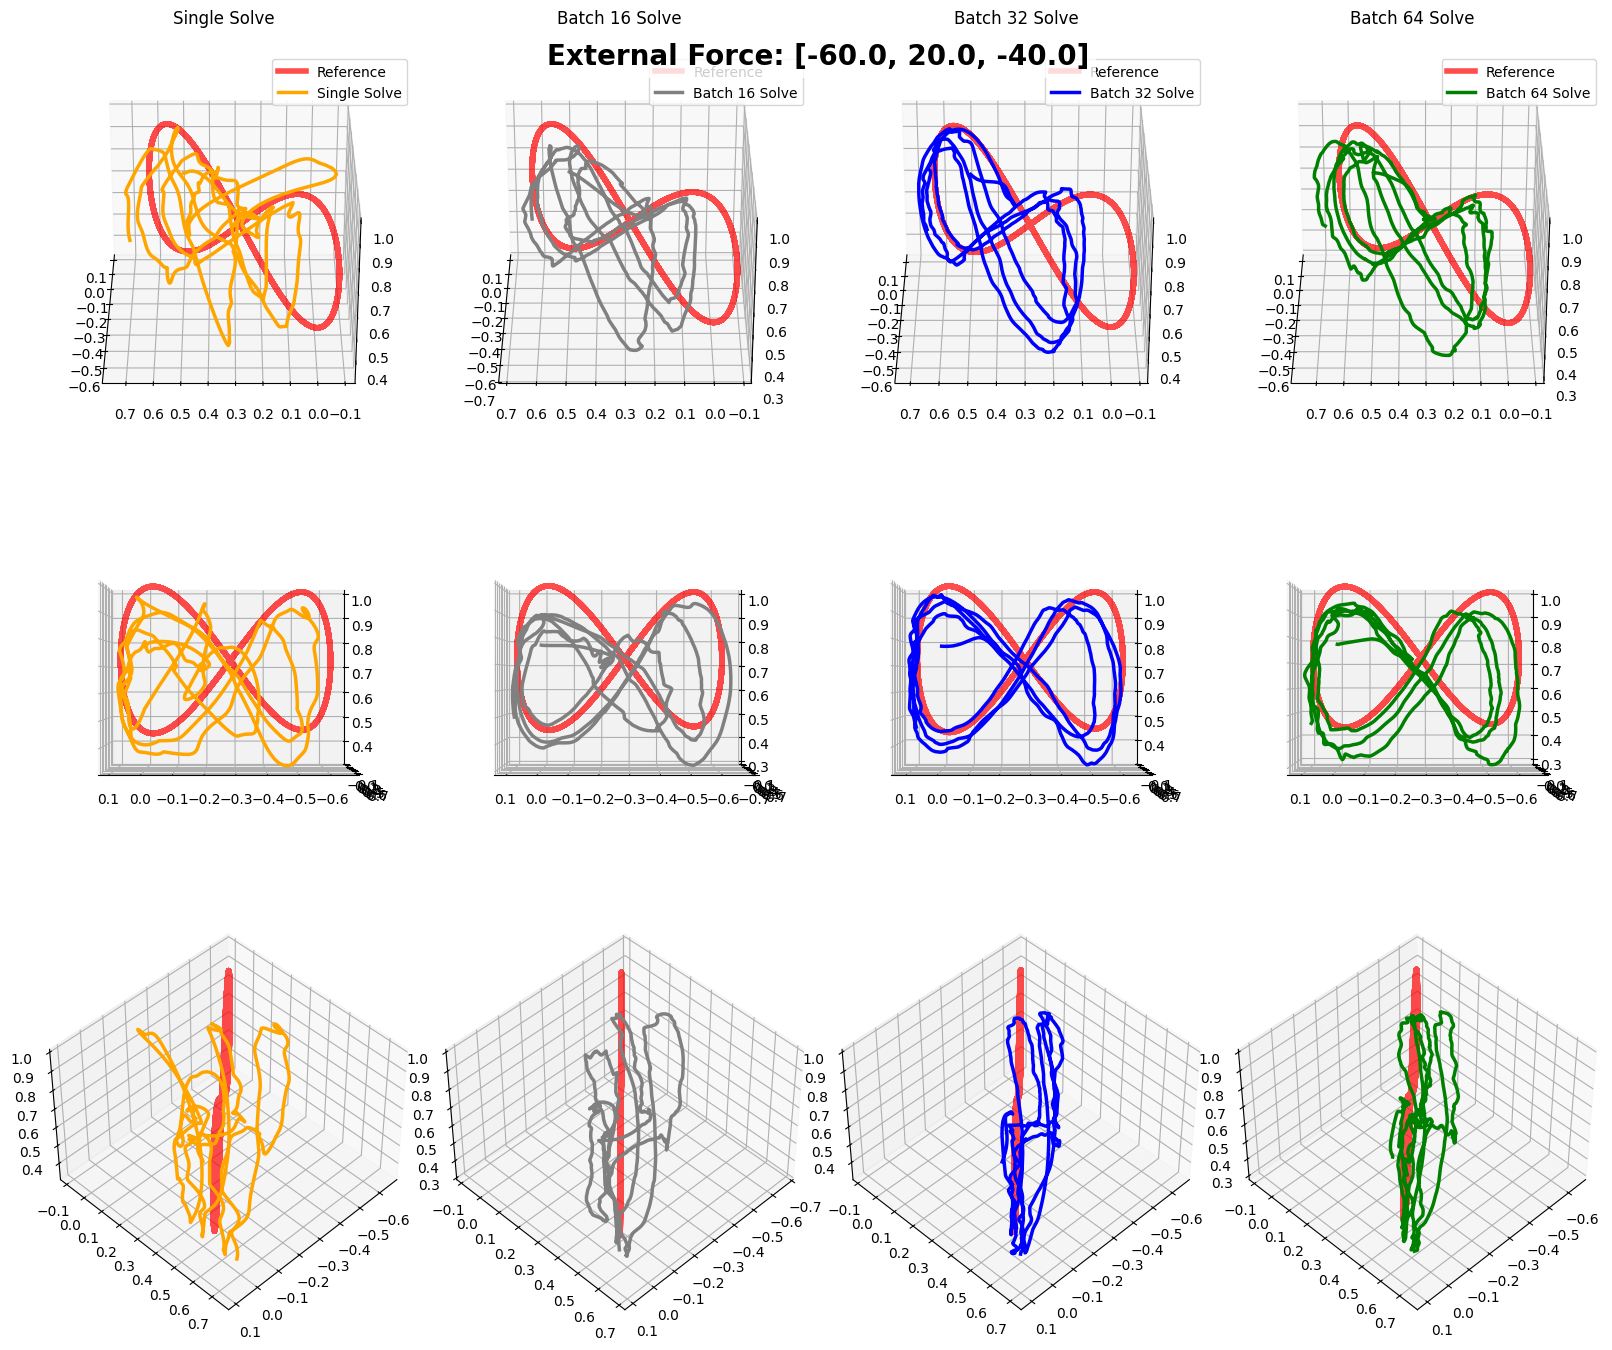

In [396]:
f_ext_actual = [-60.0, 20.0, -40.0]

ref_traj = figure8(A_x=0.5, A_z=0.55, 
                    offset=[0.0, 0.4, 0.45], 
                    period=10, 
                    dt=0.01, 
                    cycles=10).reshape(-1, 6)
        
# plot ee positions in 3d
ee_positions = np.load(f"{path}_ee_positions.npy")
batch_16_ee_positions = np.load(f"{batch_16_path}_ee_positions.npy")
batch_32_ee_positions = np.load(f"{batch_32_path}_ee_positions.npy")
batch_64_ee_positions = np.load(f"{batch_64_path}_ee_positions.npy")
    
fig = plt.figure(figsize=(16, 14))

# View angles for each row
views = [
    (30, 180, ""),
    (0, 90, ""),
    (45, 45, "")
]

for row, (elev, azim, title) in enumerate(views):
    # Create 3 subplots in current row for different solves
    for col in range(4):
        ax = fig.add_subplot(3, 4, row*4 + col + 1, projection='3d')
        
        # Plot reference trajectory in all subplots
        ax.plot(ref_traj[:, 0], ref_traj[:, 1], ref_traj[:, 2], 'red', label='Reference', linewidth=4, alpha=0.7)
        
        # Plot different solve methods in each column
        if col == 0:
            ax.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], 'orange', label='Single Solve', linewidth=2.5)
            if row == 0:
                ax.legend()
                ax.set_title(f'Single Solve\n{title}')
        elif col == 1:
            ax.plot(batch_16_ee_positions[:, 0], batch_16_ee_positions[:, 1], batch_16_ee_positions[:, 2], 'gray', label='Batch 16 Solve', linewidth=2.5) 
            if row == 0:
                ax.legend()
                ax.set_title(f'Batch 16 Solve\n{title}')    
        elif col == 2:
            ax.plot(batch_32_ee_positions[:, 0], batch_32_ee_positions[:, 1], batch_32_ee_positions[:, 2], 'blue', label='Batch 32 Solve', linewidth=2.5)
            if row == 0:
                ax.legend()
                ax.set_title(f'Batch 32 Solve\n{title}')
        elif col == 3:
            ax.plot(batch_64_ee_positions[:, 0], batch_64_ee_positions[:, 1], batch_64_ee_positions[:, 2], 'green', label='Batch 64 Solve', linewidth=2.5)
            if row == 0:
                ax.legend()
                ax.set_title(f'Batch 64 Solve\n{title}')
            
        # ax.set_xlabel('X')
        # ax.set_ylabel('Y')
        # ax.set_zlabel('Z')
        ax.view_init(elev, azim)
        
        

# Add overall title showing external force
plt.tight_layout()
plt.suptitle(f'External Force: {f_ext_actual}', y=0.95, fontsize=20, weight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=5))
plt.show()


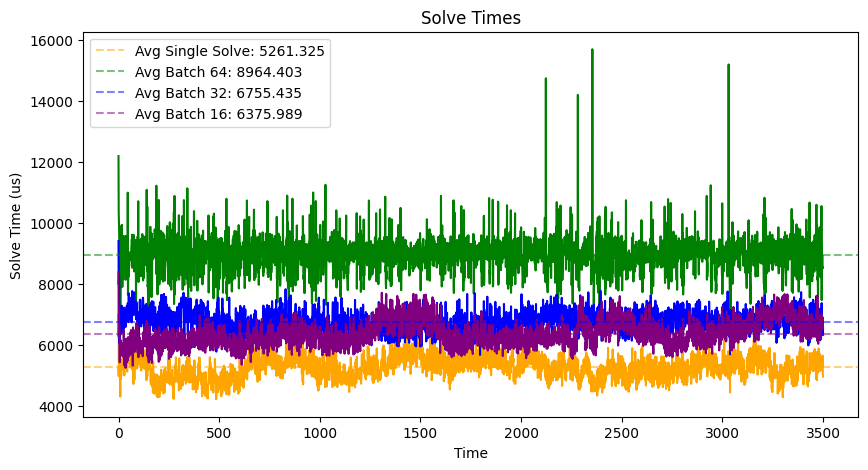

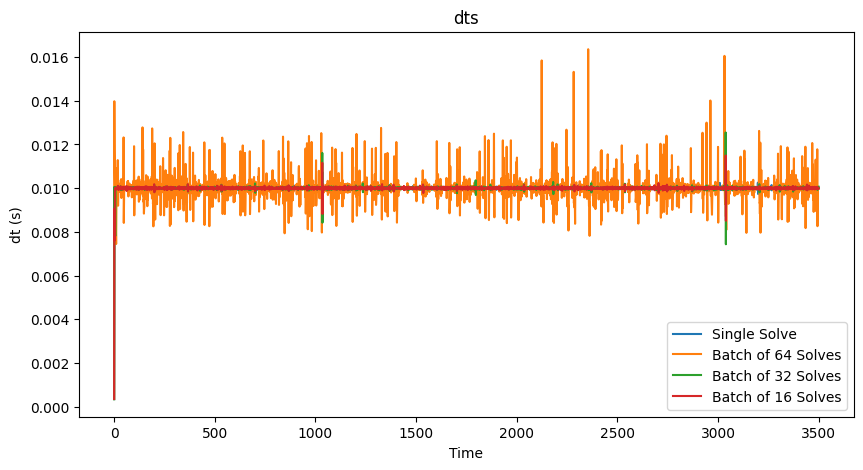

In [403]:

# ----- plot solve times -----
solve_times = np.load(f"{path}_solve_times.npy")
batch_64_solve_times = np.load(f"{batch_64_path}_solve_times.npy")
batch_32_solve_times = np.load(f"{batch_32_path}_solve_times.npy")
batch_16_solve_times = np.load(f"{batch_16_path}_solve_times.npy")

plt.figure(figsize=(10, 5))
plt.plot(solve_times, color='orange')
plt.plot(batch_64_solve_times, color='green')
plt.plot(batch_32_solve_times, color='blue')
plt.plot(batch_16_solve_times, color='purple')

# Calculate and plot average solve time
avg = np.mean(solve_times)
batch_64_avg = np.mean(batch_64_solve_times)
batch_32_avg = np.mean(batch_32_solve_times)
batch_16_avg = np.mean(batch_16_solve_times)
plt.axhline(y=avg, color='orange', linestyle='--', alpha=0.5, label=f'Avg Single Solve: {avg:.3f}')
plt.axhline(y=batch_64_avg, color='green', linestyle='--', alpha=0.5, label=f'Avg Batch 64: {batch_64_avg:.3f}')
plt.axhline(y=batch_32_avg, color='blue', linestyle='--', alpha=0.5, label=f'Avg Batch 32: {batch_32_avg:.3f}')
plt.axhline(y=batch_16_avg, color='purple', linestyle='--', alpha=0.5, label=f'Avg Batch 16: {batch_16_avg:.3f}')

plt.title("Solve Times")
plt.xlabel("Time")
plt.ylabel("Solve Time (us)")
plt.legend()
plt.show()

# ----- plot delta_ts -----
f_ext_dts = np.load(f"{path}_dts.npy")
batch_16_dts = np.load(f"{batch_16_path}_dts.npy")
batch_32_dts = np.load(f"{batch_32_path}_dts.npy")
batch_64_dts = np.load(f"{batch_64_path}_dts.npy")

plt.figure(figsize=(10, 5))
plt.plot(f_ext_dts, label='Single Solve')
plt.plot(batch_64_dts, label='Batch of 64 Solves')
plt.plot(batch_32_dts, label='Batch of 32 Solves')
plt.plot(batch_16_dts, label='Batch of 16 Solves')
plt.title("dts")
plt.xlabel("Time")
plt.ylabel("dt (s)")
plt.legend()
plt.show()

In [274]:

from utils import *
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat.geometry as g
import meshcat.transformations as tf

joint_positions = np.load(f"{path}_joint_positions.npy")
batch_joint_positions = np.load(f"{batch_path}_joint_positions.npy")

print(batch_joint_positions[1000])

model_dir = "description/"
urdf_path = model_dir + "indy7.urdf"
model, visual_model, collision_model = load_robot_model(urdf_path, model_dir)

viz = MeshcatVisualizer(model, collision_model, visual_model)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot1")#  , color=[0.0, 0.0, 0.0, 0.0])

ref_traj = figure8(A_x=0.35, A_z=0.4, 
                    offset=[0.0, 0.5, 0.5], 
                    period=10, 
                    dt=0.01, 
                    cycles=10)

for i in range(int(len(ref_traj)/6)):
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.02), 
        g.MeshLambertMaterial(color=0xff0000))
    T = tf.translation_matrix(np.array(ref_traj[6*i:6*(i+1)][:3]))
    viz.viewer[f'point{i}'].set_transform(T)
    
while True:
    viz.play(q_trajectory=batch_joint_positions, dt=0.01)

[ 2.55630228 -0.28334482 -1.55047552  1.97332852 -1.24094316 -0.01040631]
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7031/static/


KeyboardInterrupt: 

In [404]:
# Load two robot models
model1, visual_model1, collision_model1 = load_robot_model(urdf_path, model_dir)
model2, visual_model2, collision_model2 = load_robot_model(urdf_path, model_dir)

# Setup single visualizer
viz = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot1", color=[1.0, 0.0, 0.0, 0.5])

viz_2 = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz_2.initViewer(viz.viewer)

# Load second robot model into the same visualizer with a different prefix
viz_2.loadViewerModel(rootNodeName="robot2", color=[0.0, 1.0, 0.0, 0.5])

for i in range(int(len(ref_traj)/6)):
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.02), 
        g.MeshLambertMaterial(color=0xff0000))
    T = tf.translation_matrix(np.array(ref_traj[i]))
    viz.viewer[f'point{i}'].set_transform(T)
    
q_trajectory1 = joint_positions
q_trajectory2 = batch_joint_positions

# Now you can display both trajectories
while True:
    # Display first trajectory on the first robot
    viz.display(q_trajectory1[0])  # Display current state of first trajectory
    
    # Display second trajectory on the second robot
    viz_2.display(q_trajectory2[0])  # Display current state of second trajectory
    
    # Update both trajectories
    q_trajectory1 = q_trajectory1[1:]  # Move to next state
    q_trajectory2 = q_trajectory2[1:]  # Move to next state
    
    time.sleep(0.005)  # Control the display rate

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7034/static/


/home/alex/a2r/GATO/examples/indy7-mpc/.venv/lib/python3.10/site-packages/cmeel.prefix/lib/python3.10/site-packages/pinocchio/visualize/meshcat_visualizer.py:913: DeprecatedWarning: The 'color' argument is deprecated and will be removed in a future version of Pinocchio. Consider using 'collision_color' and 'visual_color' instead.
  warnings.warn(


KeyboardInterrupt: 